## Install Packages

In [ ]:
!pip install ray[tune]

In [15]:
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu117
0.15.2+cu117


## Import 

In [5]:
import sys
from pathlib import Path
from time import sleep
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import seaborn as sn
import pandas as pd
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision import datasets, transforms, models
from torchinfo import summary
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from torchmetrics import ConfusionMatrix
from torch.optim.lr_scheduler import ExponentialLR
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import time
import copy
from utilities.helper import save_model, get_num_correct, create_target_dir

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [10]:
torch.manual_seed(42)

In [11]:
torch.manual_seed(42)
torch.rand(4)

tensor([0.8823, 0.9150, 0.3829, 0.9593])

# Setup

In [32]:
## Unzip the data 

In [4]:
CURRENT_DIR = os.getcwd()
#DATA_DIR = 'Datasets/Clothes'
#PATH_TO_DATA =  os.path.join(CURRENT_DIR,DATA_DIR)
#print(PATH_TO_DATA)

In [5]:
DATA_DIR = Path('Datasets/Clothes')

DATA_DIR

PosixPath('Datasets/Clothes')

# Visualize an image

In [6]:
import random
from PIL import Image

# set seed
#random.seed(42)
# Get all image paths 
image_path_list = list(DATA_DIR.glob('*/*.jpg'))
 
# Get random image path
random_image_path = random.choice(image_path_list)

# Get image class from path name 
image_class = random_image_path.parent.stem

# Open Image
img = Image.open(random_image_path)

Random image path: Datasets/Clothes/Rima/59.jpg
Image class: Rima
Image height: 256
Image width: 256
Image color_channels: 3


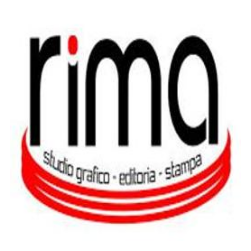

In [7]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
print(f"Image color_channels: {img_as_array.shape[2]}")
# Turn the image into an array

# Plot the image with matplotlib
plt.figure(figsize=(5, 3))
plt.imshow(img_as_array)
plt.axis(False);

In [8]:
import torch
print("Number of CUDA devices available:", torch.cuda.device_count())

num_workers = os.cpu_count()
print(num_workers)

Number of CUDA devices available: 1
24


In [9]:
class PadTensor(object):
    def __init__(self, padding):
        # Padding can be a single integer or a tuple (left, right, top, bottom)
        self.padding = padding  

    def __call__(self, tensor):
        # Pad the tensor and specify the padding mode
        # 'constant' mode adds constant valued padding, and 0 is the padding value
        return torch.nn.functional.pad(tensor, self.padding, mode='constant', value=0)

## Data augmentaion and normalizaion

In [10]:
# Create transform function
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   
    #transforms.RandomResizedCrop(224),
    #transforms.RandomHorizontalFlip(p=0.5), # data augmentation
    #transforms.RandomRotation(45),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    #transforms.Lambda(lambda image: image.convert('RGB')),
    #transforms.RandomRotation(85),
    #transforms.Grayscale(num_output_channels=3),
    #transforms.GaussianBlur(kernel_size = (7,13), sigma = (6 , 7)),
    #transforms.ColorJitter(brightness=(0.5,1.5),contrast=(2),saturation=(1.4),hue=(-0.1,0.5)),
    transforms.ToTensor(),
    #PadTensor(padding=(1, 1, 1, 1)),  # Applies padding to the tensor
    transforms.Normalize(mean, std) # normalization
])
transforms_valid = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.CenterCrop((224, 224)),
    #transforms.RandomRotation(45),
    transforms.ToTensor(),
    #PadTensor(padding=(1, 1, 1, 1)),  # Applies padding to the tensor
    transforms.Normalize(mean, std)
])

data_transforms = {
    'train': transforms_train,
    'valid': transforms_valid,
}

In [11]:
transforms_train(img).shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


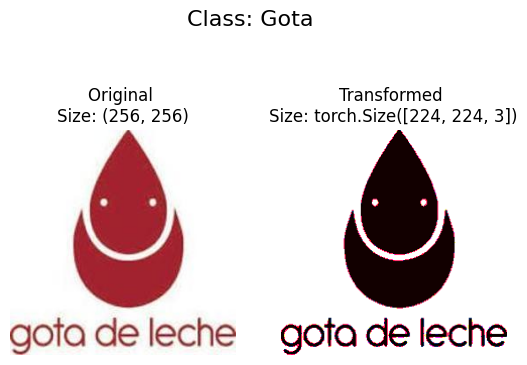

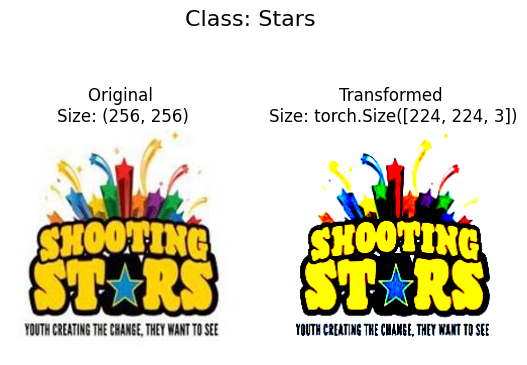

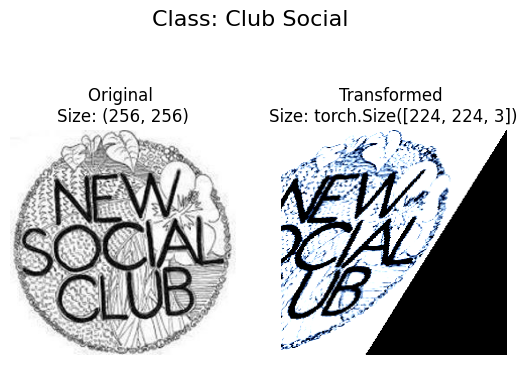

In [12]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=transforms_train, 
                        n=3)

In [13]:
from typing import Tuple, Dict, List
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

## Load Data

## Set up path for data after downloading

In [14]:
from torch.utils.data import random_split
from sklearn.model_selection import KFold
# Load the dataset

# Ensure all files are valid images
def is_valid_file(path):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp']
    return os.path.splitext(path)[1].lower() in valid_extensions

# Load the dataset with valid file checker
try:
    dataset = datasets.ImageFolder(DATA_DIR, is_valid_file=is_valid_file, transform=None)
    print("Dataset loaded successfully.")
    
    random.seed(42)
    # Split the dataset into train and test sets
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, valid_dataset = random_split(dataset, [train_size, test_size])

    # Apply different transforms to train and test datasets using a custom Dataset
    class CustomDataset(torch.utils.data.Dataset):
        def __init__(self, dataset, transform=None):
            self.dataset = dataset
            self.transform = transform

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            image, label = self.dataset[idx]
            if self.transform:
                image = self.transform(image)
            return image, label

    # Create datasets with appropriate transformations
    train_dataset = CustomDataset(train_dataset, transform=transforms_train)
    valid_dataset = CustomDataset(valid_dataset, transform=transforms_valid)
except Exception as e:
    print(f"Error loading dataset: {e}")
#dataset = datasets.ImageFolder(DATA_DIR, transform=None)

Dataset loaded successfully.


In [15]:
print(len(train_dataset))
print(len(valid_dataset))

16450
4113


In [16]:
img, label = train_dataset[0]

In [17]:
train_dataset.transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ToTensor()
    Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
)

In [18]:
batch_size = 24


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                               num_workers=4)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print('Train dataset size:', len(train_dataset))
print('Valid dataset size:', len(valid_dataset))
class_names = dataset.classes
#print('Class names:', class_names)

num_classes = len(class_names)
print('Class numbers:', num_classes)
print()
print('Train dataloader size (number of batches):', len(train_dataloader))
print('Valid dataloader size (number of batches):', len(valid_dataloader))
print('Train dataset size:', len(train_dataloader.dataset))
print('Valid dataset size::', len(valid_dataloader.dataset))

Train dataset size: 16450
Valid dataset size: 4113
Class numbers: 287

Train dataloader size (number of batches): 686
Valid dataloader size (number of batches): 172
Train dataset size: 16450
Valid dataset size:: 4113


#  Visualize data after transformation

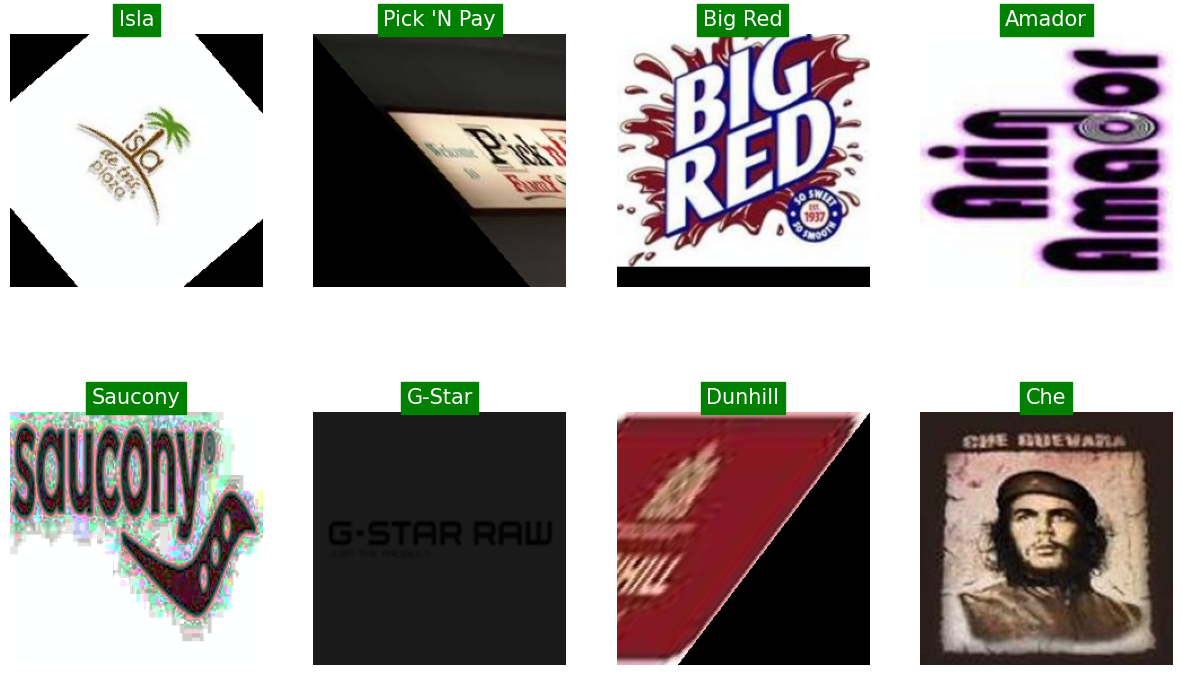

In [19]:
fig = plt.figure(figsize=(15,9))
rows, cols = 2, 4

# Load a batch of train images
iterator = iter(train_dataloader)
inputs, classes = next(iterator)
def imshow(input, title, ax):
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    ax.imshow(input)
    ax.set_title(title, fontsize=15, color='white', backgroundcolor='green')
    ax.axis('off')  # Hide axes

# Loop through the first 8 images in the batch
for i in range(1, 9):
    ax = fig.add_subplot(rows, cols, i)
    # Display each image in its subplot
    imshow(inputs[i - 1], class_names[classes[i - 1]], ax)

plt.show()

## Load pre-trained ResNet-18 model 

In [20]:
class Resnet50(nn.Module):
    def __init__(self, num_classes, pretrained, fine_tune):
        super(Resnet50, self).__init__()
        self.model = models.resnet50(pretrained=pretrained)
                # Remove the original fully connected layer
        num_features = self.model.fc.in_features
        self.model.fc = nn.Identity()  # Remove the last layer
        
        # Assuming the features output from Resnet50 is of size 2048
        self.classifier_layer = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(num_features, 1024),
            nn.BatchNorm1d(1024),
            #nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            #nn.ReLU(),
            nn.Linear(512, num_classes),
            nn.BatchNorm1d(num_classes)
            #nn.Linear(128, num_classes)
            # nn.LogSoftmax(dim=1)
        )
        model_name = self.__class__.__name__
        print(f"Model: {model_name}")
        print(f'[INFO]: Number of infeatures:{num_features}')
        if fine_tune:
            print('[INFO]: Fine-tuning all layers...')
            for params in model.parameters():
                params.requires_grad = True
        elif not fine_tune:
            print('[INFO]: Freezing hidden layers...')
            self.freeze_layers()
        
    def forward(self, x):
        # Extract features from the base model
        x = self.model(x)  # Here, x will be the output from the average pooling layer
        # Flatten the features
        x = torch.flatten(x, 1)
        # Pass features through the new classifier layers
        x = self.classifier_layer(x)
        return x
    
    def freeze_layers(self):
        # Freeze layers except for 'layer3', 'layer4', and 'classifier_layer'
        for name, child in self.model.named_children():
            if name in ['layer3', 'layer4']:
                for param in child.parameters():
                    param.requires_grad = True
            else:
                for param in child.parameters():
                    param.requires_grad = False 
            
        for params in self.classifier_layer.parameters():
            params.requires_grad = True

In [21]:
class Resnet18(nn.Module):
    def __init__(self, num_classes, pretrained, fine_tune):
        super(Resnet18, self).__init__()
        self.model = models.resnet18(pretrained=pretrained)
                # Remove the original fully connected layer
        num_features = self.model.fc.in_features
        self.model.fc = nn.Identity()  # Remove the last layer
        # Assuming the features output from Resnet50 is of size 2048
        self.classifier_layer = nn.Sequential(
            nn.Dropout(p=0.3, inplace=False),
            nn.Linear(num_features, num_classes),
            nn.BatchNorm1d(num_classes),
            #nn.Linear(128, num_classes)
            # nn.LogSoftmax(dim=1)
            #nn.ReLU(),  # Optional: Add if you want to add non-linearity
            #nn.Softmax(dim=1)  # Optional: Add if you need probabilities
        )
        
    
        model_name = self.__class__.__name__
        print(f"Model: {model_name}")
        print(f'[INFO]: Number of infeatures:{num_features}')
        if fine_tune:
            print('[INFO]: Fine-tuning all layers...')
            for params in self.model.parameters():
                params.requires_grad = True
        elif not fine_tune:
            print('[INFO]: Freezing hidden layers...')
            self.freeze_layers()
        
    def forward(self, x):
        # Extract features from the base model
        x = self.model(x)  # Here, x will be the output from the average pooling layer
        # Flatten the features
        x = torch.flatten(x, 1)
        # Pass features through the new classifier layers
        x = self.classifier_layer(x)
        return x
    
    def freeze_layers(self):
        # Freeze layers except for 'layer3', 'layer4', and 'classifier_layer'
        for name, child in self.model.named_children():
            if name in ['layer3', 'layer4']:
                for param in child.parameters():
                    param.requires_grad = True
            else:
                for param in child.parameters():
                    param.requires_grad = False 
            
        for params in self.classifier_layer.parameters():
            params.requires_grad = True  

In [22]:
#model = Resnet18(num_classes=num_classes, pretrained=True, fine_tune=False)
model = Resnet50(num_classes=num_classes, pretrained=True, fine_tune=False)

NameError: name 'models' is not defined

In [ ]:
model.classifier_layer

In [ ]:
from utilities.helper import save_model, create_target_dir

SAVE_MODEL_TO = 'models'
target_dir =create_target_dir(SAVE_MODEL_TO)

In [ ]:
checkpoint_path= create_dir(path=target_dir, dir_name="Checkpoints" )

In [27]:
from torch.optim import lr_scheduler
from timm.data.mixup import Mixup
#model.fc = nn.Sequential(
#    nn.Dropout(0.5), 
#    nn.Linear(num_features, num_classes)
#    )
# Move the model to the GPU if available

lr = 5e-3
num_epochs = 300
patience = 12
label_smoothing=0.1
warmup_epochs=5
stop_lr = 10
base_lr=5e-3
final_lr=1e-5
momentum = 0.9

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

# Loss functions
#criterion_kd = nn.KLDivLoss()
#criterion_ce = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(target_dir, patience=patience, min_delta=0, verbose=True)
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss(label_smoothing=label_smoothing) #label_smoothing=0.1 # weight=class_weights_tensor


# I can use other optimizers like adam
#optimizer = FusedLAMB(model.parameters(), lr=5e-3)
#optimizer = optim.AdamW(model.parameters(), lr=0.000025, weight_decay=0.001)
optimizer = optim.Adam(model.parameters(), lr=lr, momentum=momentum)# Use all parameters
# Optimizers to compare ##TODO
#optimizers = {
#    'SGD': optim.SGD(model.parameters(), lr=lr, momentum=0.9),
#    'Adam': optim.Adam(model.parameters(), lr=0.0001),
#    'RMSprop': optim.RMSprop(model.parameters(), lr=0.0001)
    # Add any other optimizers you want to compare
#}

if checkpoint_dir:
    checkpoint = torch.load(os.path.join(checkpoint_dir, "checkpoint"))
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
exp_lr_scheduler = ASHAScheduler(
    metric="accuracy",
    mode="max",
    max_t=10,
    grace_period=1,
    reduction_factor=2
)
reporter = CLIReporter(
    parameter_columns=["lr", "momentum", "batch_size"],
    metric_columns=["loss", "accuracy", "training_iteration"]
)
#exp_lr_scheduler = CustomLRScheduler(optimizer, warmup_epochs=warmup_epochs, stop_lr=stop_lr, total_epochs=num_epochs, base_lr=base_lr, final_lr=final_lr)
##exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
#exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#mixup_fn = Mixup(mixup_alpha=0.2, cutmix_alpha=1.0, cutmix_minmax=None, prob=1.0, switch_prob=0.5, mode='batch', label_smoothing=0.1, num_classes=num_classes)


#torch.manual_seed(42)
#torch.cuda.manual_seed(42)

cuda:0


NameError: name 'model' is not defined

In [ ]:
import json
settings = { 'num_epochs': num_epochs, 'batch_size':batch_size, "EarlyStopping_patience":patience,
            'criterion': 'CrossEntropyLoss', 'momentum':momentum , 'label_smoothing':label_smoothing,
             'optimizer': 'Adam', 'lr': lr, 'warmup_epochs':warmup_epochs , 'stop_lr':stop_lr , 
            'base_lr':base_lr, 'final_lr':final_lr
}

with open(f'{target_dir}/settings.json', 'w') as file:
    json.dump(settings, file)

# TENSORBOARD

In [235]:
#train_loader = train_dataloader
#valid_loader = dataloaders['valid']

In [237]:
def train_model(model: torch.nn.Module,
         data_loader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
         scheduler: torch.optim.lr_scheduler._LRScheduler,
         device: torch.device):
    model.to(device)
    # training mode
    model.train()
    print('Training...')
    train_loss , train_corrects = 0.0  , 0 
    y_pred = []
    y_true = []
        # loop through the training batches..
    for batch, (inputs, labels) in tqdm(enumerate(data_loader), total=len(data_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        
        # forward inputs and get output
        outputs = model(inputs)

        # Calculate loss (per batch)
        loss = loss_fn(outputs, labels)
        train_loss += loss.item() * inputs.size(0)
            
        optimizer.zero_grad()
        
        loss.backward()

        optimizer.step()
        
         # Calculate Accuracy
        _, preds = torch.max(outputs.data, 1)
        train_corrects += get_num_correct(preds, labels)
                # Extend 
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

        #if batch % 100 == 0:
            #print(f'Looked at {batch * len(inputs)}/{len(data_loader.dataset)} samples.')
                

    #scheduler.step()    
    avg_train_loss = train_loss / len(data_loader.dataset)
    avg_train_acc = train_corrects / len(data_loader.dataset) * 100
    weighted_f1 = f1_score(y_true, y_pred, average='weighted') *100

    # Print progress
    return avg_train_loss, avg_train_acc, weighted_f1

In [238]:
def valid_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    model.to(device)
    model.eval()
    print('Validation...')
    val_loss = 0.0
    val_corrects = 0
    y_pred = []
    y_true = []
    for batch, (inputs, labels) in tqdm(enumerate(data_loader), total=len(data_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        # Calculate loss (per batch)
        loss = loss_fn(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        
         # Calculate Accuracy
        _, preds = torch.max(outputs.data, 1)
        val_corrects += get_num_correct(preds, labels)
        
        # Extend 
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

    avg_valid_loss = val_loss / len(data_loader.dataset)
    avg_valid_acc = val_corrects / len(data_loader.dataset) * 100

    # Calculate the weighted F1 score
    weighted_f1 = f1_score(y_true, y_pred, average='weighted') *100

    return [avg_valid_loss, avg_valid_acc, y_pred, y_true, weighted_f1]

## Train the model on custom data 

In [239]:
model.classifier_layer

Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=2048, out_features=1024, bias=True)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Linear(in_features=512, out_features=287, bias=True)
  (6): BatchNorm1d(287, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [240]:
from contextlib import contextmanager


@contextmanager
def log_stdout_to_file(filepath):
    # Save the current stdout and stderr so we can restore them later
    old_stdout = sys.stdout
    old_stderr = sys.stderr
    try:
        # Open the log file in append mode
        with open(filepath, 'a') as file:
            # Define a helper function to handle the output
            def write_to_both(text):
                old_stdout.write(text)  # Write to standard output
                file.write(text)        # Write to file

            # Create a class that overrides the write and flush methods
            class SplitOutput:
                def write(self, message):
                    write_to_both(message)

                def flush(self):
                    old_stdout.flush()
                    file.flush()

            # Set this new output class as the current stdout and stderr
            sys.stdout = sys.stderr = SplitOutput()
            yield
    finally:
        # Restore the original stdout and stderr
        sys.stdout = old_stdout
        sys.stderr = old_stderr

In [241]:
# Initialize best accuracy and initialize model weights
class_names = dataset.classes
num_classes = len(class_names)

#batch_size = 32
num_epochs = 50

# train
epoch_train_loss=[]
train_accuracy=[]
train_weighted_f1=[]
# valid
valid_loss=[]
valid_accuracy=[]
valid_weighted_f1=[]

best_acc = 0.0
y_pred = []
y_true = []

tb = SummaryWriter()
images, labels = next(iter(train_dataloader))
images, labels = images.to(device), labels.to(device)
grid = torchvision.utils.make_grid(images)

tb.add_image('images', grid)
tb.add_graph(model, images)
with log_stdout_to_file(f'{target_dir}/experiment_log.txt'):
    print(f"[INFO]: Number of training images: {len(train_dataset)}")
    print(f"[INFO]: Number of validation images: {len(valid_dataset)}")
    print(f"[INFO]: NUmber of Classes: {len(class_names)}\n")

        # Setup target device  
    print(f"Computation device: {device}")
    print(f"Learning rate: {lr}")
    print(f"Batch Size: {batch_size}")
    print(f"Epochs to train for: {num_epochs}\n")
    print(summary(model, input_size=(32,3,224,224)))
    print(f'\nclassifier_layer: {model.classifier_layer}\n')
start_time = time.time()
# Start Training loop
for epoch in range(num_epochs):
    print(f"[INFO]: Epoch {epoch+1} of {num_epochs}")
            #print("Epoch {}/{} running....".format(epoch+1, num_epochs)) #(printing message)    
    """ Training Phase """
    avg_train_loss, avg_train_acc, weighted_f1 = train_model(model, train_dataloader, loss_fn, optimizer,exp_lr_scheduler, device)
        # Append result
    epoch_train_loss.append(avg_train_loss)
    train_accuracy.append(avg_train_acc)
    train_weighted_f1.append(weighted_f1)
        
        # Tensorboard
    tb.add_scalar('Training Loss', avg_train_loss ,epoch)
    tb.add_scalar('Training Accuracy', avg_train_acc ,epoch)
    tb.add_scalar('Training F1 Score', weighted_f1 ,epoch)


    """ Validation Phase """
    history = valid_model(model, valid_dataloader, loss_fn, device)
    #exp_lr_scheduler.step(history[1])
    # Append result
    valid_loss.append(history[0])
    valid_accuracy.append(history[1])
    valid_weighted_f1.append(history[4])
    y_pred.extend(history[2])
    y_true.extend(history[3])
        
        # Tensorboard
    tb.add_scalar('Validation Loss', history[0] ,epoch)
    tb.add_scalar('Validation Accuracy', history[1] ,epoch)
    tb.add_scalar('Validation F1 Score', history[4] ,epoch)
        
    #tb.add_histogram('fc.Linear.bias', model.fc[8].bias, epoch)
    #tb.add_histogram('fc.Linear.weight', model.fc[8].weight, epoch)
    #tb.add_histogram('fc.Linear.weight.grad', model.fc[8].weight.grad, epoch)
        
    print('[INFO] Training Loss: {:.4f} | Acc: {:.4f}% | Weighted F1: {:.4f}'.format(avg_train_loss, avg_train_acc, weighted_f1))
    print('[INFO] Validation Loss: {:.4f} | Acc: {:.4f}% | Weighted F1: {:.4f}'.format(history[0], history[1], history[4]))                      # Save the best model
    if history[1] > best_acc:
        best_acc = history[1]
        print('Improvement-Detected, Best model updated')
        save_model(model=model, target_dir=target_dir, model_name='resnet_best.pth')
    print('-'*80)
    time.sleep(3)
with log_stdout_to_file(f'{target_dir}/experiment_log.txt'):
    save_model(model=model, target_dir=target_dir, model_name='resnet_last.pth')
    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}%'.format(best_acc))

[INFO]: Number of training images: 16450
[INFO]: Number of validation images: 4113
[INFO]: NUmber of Classes: 287

Computation device: cuda:0
Learning rate: 0.001
Batch Size: 24
Epochs to train for: 50

Layer (type:depth-idx)                        Output Shape              Param #
Resnet50                                      [32, 287]                 --
├─ResNet: 1-1                                 [32, 2048]                --
│    └─Conv2d: 2-1                            [32, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                       [32, 64, 112, 112]        (128)
│    └─ReLU: 2-3                              [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [32, 64, 56, 56]          --
│    └─Sequential: 2-5                        [32, 256, 56, 56]         --
│    │    └─Bottleneck: 3-1                   [32, 256, 56, 56]         (75,008)
│    │    └─Bottleneck: 3-2                   [32, 256, 56, 56]         (70,400)
│    │    └─Bottleneck

100%|██████████| 686/686 [00:54<00:00, 12.67it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.54it/s]


[INFO] Training Loss: 5.7095 | Acc: 1.2523% | Weighted F1: 0.6529
[INFO] Validation Loss: 5.4938 | Acc: 2.1396% | Weighted F1: 0.6653
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 2 of 50
Training...


100%|██████████| 686/686 [00:53<00:00, 12.87it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.65it/s]


[INFO] Training Loss: 5.4363 | Acc: 2.8997% | Weighted F1: 1.2317
[INFO] Validation Loss: 5.2799 | Acc: 5.4705% | Weighted F1: 2.7173
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 3 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.53it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.68it/s]


[INFO] Training Loss: 5.2204 | Acc: 5.1003% | Weighted F1: 2.2057
[INFO] Validation Loss: 5.0677 | Acc: 7.0994% | Weighted F1: 3.4287
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 4 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.70it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.78it/s]


[INFO] Training Loss: 5.0866 | Acc: 6.9726% | Weighted F1: 3.3931
[INFO] Validation Loss: 4.9372 | Acc: 8.8257% | Weighted F1: 4.8086
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 5 of 50
Training...


100%|██████████| 686/686 [00:53<00:00, 12.93it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.64it/s]


[INFO] Training Loss: 4.9915 | Acc: 8.1459% | Weighted F1: 4.1478
[INFO] Validation Loss: 4.8296 | Acc: 10.0170% | Weighted F1: 5.5278
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 6 of 50
Training...


100%|██████████| 686/686 [00:53<00:00, 12.77it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.72it/s]


[INFO] Training Loss: 4.9029 | Acc: 9.2827% | Weighted F1: 4.8926
[INFO] Validation Loss: 4.7459 | Acc: 12.3025% | Weighted F1: 8.0127
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 7 of 50
Training...


100%|██████████| 686/686 [00:53<00:00, 12.74it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.48it/s]


[INFO] Training Loss: 4.8172 | Acc: 10.3708% | Weighted F1: 5.9087
[INFO] Validation Loss: 4.6568 | Acc: 13.5424% | Weighted F1: 8.4965
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 8 of 50
Training...


100%|██████████| 686/686 [00:53<00:00, 12.84it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.69it/s]


[INFO] Training Loss: 4.7247 | Acc: 11.9027% | Weighted F1: 7.0151
[INFO] Validation Loss: 4.5434 | Acc: 15.1714% | Weighted F1: 9.5030
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 9 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.54it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.48it/s]


[INFO] Training Loss: 4.6424 | Acc: 13.1185% | Weighted F1: 8.1000
[INFO] Validation Loss: 4.5225 | Acc: 14.8067% | Weighted F1: 9.3110
--------------------------------------------------------------------------------
[INFO]: Epoch 10 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.60it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.61it/s]


[INFO] Training Loss: 4.5416 | Acc: 14.2128% | Weighted F1: 9.3849
[INFO] Validation Loss: 4.3511 | Acc: 18.7698% | Weighted F1: 13.5405
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 11 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.62it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.61it/s]


[INFO] Training Loss: 4.4484 | Acc: 15.9271% | Weighted F1: 10.8477
[INFO] Validation Loss: 4.2885 | Acc: 19.3533% | Weighted F1: 14.4121
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 12 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.65it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.65it/s]


[INFO] Training Loss: 4.3501 | Acc: 17.6353% | Weighted F1: 12.6587
[INFO] Validation Loss: 4.1682 | Acc: 22.4167% | Weighted F1: 17.5490
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 13 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.62it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.20it/s]


[INFO] Training Loss: 4.2490 | Acc: 19.8480% | Weighted F1: 14.9244
[INFO] Validation Loss: 4.0750 | Acc: 24.2402% | Weighted F1: 18.8600
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 14 of 50
Training...


100%|██████████| 686/686 [00:53<00:00, 12.74it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.53it/s]


[INFO] Training Loss: 4.1657 | Acc: 21.8784% | Weighted F1: 16.8101
[INFO] Validation Loss: 4.0483 | Acc: 24.4833% | Weighted F1: 20.0810
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 15 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.67it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.27it/s]


[INFO] Training Loss: 4.0747 | Acc: 23.7629% | Weighted F1: 19.0567
[INFO] Validation Loss: 3.9039 | Acc: 28.5923% | Weighted F1: 24.4736
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 16 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.54it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.51it/s]


[INFO] Training Loss: 3.9856 | Acc: 25.1976% | Weighted F1: 20.5558
[INFO] Validation Loss: 3.8090 | Acc: 31.3640% | Weighted F1: 27.1531
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 17 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.61it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.60it/s]


[INFO] Training Loss: 3.8928 | Acc: 27.2584% | Weighted F1: 22.8424
[INFO] Validation Loss: 3.7538 | Acc: 32.2636% | Weighted F1: 28.3249
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 18 of 50
Training...


100%|██████████| 686/686 [00:53<00:00, 12.74it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.32it/s]


[INFO] Training Loss: 3.7992 | Acc: 30.1216% | Weighted F1: 25.8912
[INFO] Validation Loss: 3.7107 | Acc: 34.5004% | Weighted F1: 30.8445
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 19 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.60it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.55it/s]


[INFO] Training Loss: 3.7258 | Acc: 31.7021% | Weighted F1: 27.6497
[INFO] Validation Loss: 3.6266 | Acc: 35.3756% | Weighted F1: 31.4498
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 20 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.69it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.23it/s]


[INFO] Training Loss: 3.6413 | Acc: 33.8116% | Weighted F1: 30.2163
[INFO] Validation Loss: 3.5914 | Acc: 36.7372% | Weighted F1: 33.9904
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 21 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.69it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.31it/s]


[INFO] Training Loss: 3.5581 | Acc: 35.9453% | Weighted F1: 32.4016
[INFO] Validation Loss: 3.5493 | Acc: 38.3175% | Weighted F1: 35.1474
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 22 of 50
Training...


100%|██████████| 686/686 [00:55<00:00, 12.45it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.36it/s]


[INFO] Training Loss: 3.4931 | Acc: 38.2006% | Weighted F1: 34.8356
[INFO] Validation Loss: 3.4721 | Acc: 39.8006% | Weighted F1: 37.1448
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 23 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.62it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.44it/s]


[INFO] Training Loss: 3.4231 | Acc: 39.5076% | Weighted F1: 36.3246
[INFO] Validation Loss: 3.4164 | Acc: 41.7214% | Weighted F1: 39.0306
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 24 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.57it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.77it/s]


[INFO] Training Loss: 3.3366 | Acc: 42.1945% | Weighted F1: 39.3009
[INFO] Validation Loss: 3.3638 | Acc: 43.1072% | Weighted F1: 40.4889
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 25 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.56it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.65it/s]


[INFO] Training Loss: 3.2746 | Acc: 44.4924% | Weighted F1: 41.9014
[INFO] Validation Loss: 3.3554 | Acc: 43.6664% | Weighted F1: 41.4296
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 26 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.63it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.74it/s]


[INFO] Training Loss: 3.2187 | Acc: 46.1398% | Weighted F1: 43.6673
[INFO] Validation Loss: 3.2960 | Acc: 44.8091% | Weighted F1: 42.5802
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 27 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.67it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.64it/s]


[INFO] Training Loss: 3.1464 | Acc: 48.1094% | Weighted F1: 45.9991
[INFO] Validation Loss: 3.2589 | Acc: 47.5079% | Weighted F1: 45.8798
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 28 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.60it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.27it/s]


[INFO] Training Loss: 3.1013 | Acc: 49.2280% | Weighted F1: 47.3360
[INFO] Validation Loss: 3.2647 | Acc: 46.9973% | Weighted F1: 46.1803
--------------------------------------------------------------------------------
[INFO]: Epoch 29 of 50
Training...


100%|██████████| 686/686 [00:55<00:00, 12.47it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.40it/s]


[INFO] Training Loss: 3.0451 | Acc: 51.2766% | Weighted F1: 49.4705
[INFO] Validation Loss: 3.1829 | Acc: 47.9942% | Weighted F1: 46.5255
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 30 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.62it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.30it/s]


[INFO] Training Loss: 2.9540 | Acc: 53.4590% | Weighted F1: 51.7672
[INFO] Validation Loss: 3.1591 | Acc: 48.2130% | Weighted F1: 46.9649
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 31 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.70it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.43it/s]


[INFO] Training Loss: 2.9214 | Acc: 54.7599% | Weighted F1: 53.3660
[INFO] Validation Loss: 3.1122 | Acc: 50.5227% | Weighted F1: 49.4129
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 32 of 50
Training...


100%|██████████| 686/686 [00:53<00:00, 12.77it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.52it/s]


[INFO] Training Loss: 2.8552 | Acc: 57.1246% | Weighted F1: 55.8018
[INFO] Validation Loss: 3.1395 | Acc: 49.6718% | Weighted F1: 49.0494
--------------------------------------------------------------------------------
[INFO]: Epoch 33 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.62it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.54it/s]


[INFO] Training Loss: 2.8004 | Acc: 58.9179% | Weighted F1: 57.7734
[INFO] Validation Loss: 3.0977 | Acc: 51.8600% | Weighted F1: 51.0919
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 34 of 50
Training...


100%|██████████| 686/686 [00:55<00:00, 12.45it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.39it/s]


[INFO] Training Loss: 2.7453 | Acc: 60.0973% | Weighted F1: 59.0080
[INFO] Validation Loss: 3.0592 | Acc: 51.7384% | Weighted F1: 50.9382
--------------------------------------------------------------------------------
[INFO]: Epoch 35 of 50
Training...


100%|██████████| 686/686 [00:53<00:00, 12.72it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.43it/s]


[INFO] Training Loss: 2.6819 | Acc: 62.2006% | Weighted F1: 61.3801
[INFO] Validation Loss: 3.0279 | Acc: 53.0999% | Weighted F1: 52.8419
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 36 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.62it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.36it/s]


[INFO] Training Loss: 2.6297 | Acc: 63.5137% | Weighted F1: 62.7021
[INFO] Validation Loss: 3.0411 | Acc: 53.1972% | Weighted F1: 52.7740
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 37 of 50
Training...


100%|██████████| 686/686 [00:55<00:00, 12.47it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.56it/s]


[INFO] Training Loss: 2.5900 | Acc: 65.1611% | Weighted F1: 64.4889
[INFO] Validation Loss: 2.9282 | Acc: 55.5069% | Weighted F1: 54.8142
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 38 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.70it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.58it/s]


[INFO] Training Loss: 2.5549 | Acc: 65.8845% | Weighted F1: 65.2908
[INFO] Validation Loss: 2.9591 | Acc: 55.6528% | Weighted F1: 55.1833
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 39 of 50
Training...


100%|██████████| 686/686 [00:53<00:00, 12.73it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.48it/s]


[INFO] Training Loss: 2.5229 | Acc: 67.0334% | Weighted F1: 66.4507
[INFO] Validation Loss: 2.9333 | Acc: 56.3822% | Weighted F1: 55.7372
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 40 of 50
Training...


100%|██████████| 686/686 [00:55<00:00, 12.42it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.31it/s]


[INFO] Training Loss: 2.4854 | Acc: 68.1398% | Weighted F1: 67.6629
[INFO] Validation Loss: 2.9149 | Acc: 56.6496% | Weighted F1: 55.7974
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 41 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.53it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.48it/s]


[INFO] Training Loss: 2.4584 | Acc: 68.7295% | Weighted F1: 68.3539
[INFO] Validation Loss: 2.8990 | Acc: 57.3061% | Weighted F1: 56.9687
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 42 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.49it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.66it/s]


[INFO] Training Loss: 2.4195 | Acc: 70.0000% | Weighted F1: 69.6674
[INFO] Validation Loss: 2.8967 | Acc: 57.4277% | Weighted F1: 57.2735
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 43 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.65it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.67it/s]


[INFO] Training Loss: 2.3760 | Acc: 71.1064% | Weighted F1: 70.8292
[INFO] Validation Loss: 2.8379 | Acc: 58.3759% | Weighted F1: 58.0549
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 44 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.58it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.69it/s]


[INFO] Training Loss: 2.3478 | Acc: 72.0061% | Weighted F1: 71.7987
[INFO] Validation Loss: 2.8484 | Acc: 58.8378% | Weighted F1: 58.5334
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 45 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.52it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.32it/s]


[INFO] Training Loss: 2.3090 | Acc: 73.3435% | Weighted F1: 73.0721
[INFO] Validation Loss: 2.8030 | Acc: 59.5429% | Weighted F1: 59.5500
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 46 of 50
Training...


100%|██████████| 686/686 [00:58<00:00, 11.79it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.54it/s]


[INFO] Training Loss: 2.2837 | Acc: 73.8906% | Weighted F1: 73.6898
[INFO] Validation Loss: 2.8580 | Acc: 59.1539% | Weighted F1: 59.0067
--------------------------------------------------------------------------------
[INFO]: Epoch 47 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.60it/s]

Validation...



100%|██████████| 172/172 [00:12<00:00, 14.27it/s]


[INFO] Training Loss: 2.2757 | Acc: 74.1277% | Weighted F1: 73.9670
[INFO] Validation Loss: 2.7923 | Acc: 60.8072% | Weighted F1: 60.4868
Improvement-Detected, Best model updated
[INFO] Saving model to: models/2024-06-06_13:6/resnet_best.pth
--------------------------------------------------------------------------------
[INFO]: Epoch 48 of 50
Training...


100%|██████████| 686/686 [00:55<00:00, 12.47it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.38it/s]


[INFO] Training Loss: 2.2525 | Acc: 74.8997% | Weighted F1: 74.6843
[INFO] Validation Loss: 2.7945 | Acc: 60.2966% | Weighted F1: 60.1429
--------------------------------------------------------------------------------
[INFO]: Epoch 49 of 50
Training...


100%|██████████| 686/686 [00:53<00:00, 12.75it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.64it/s]


[INFO] Training Loss: 2.2287 | Acc: 75.4407% | Weighted F1: 75.3313
[INFO] Validation Loss: 2.7943 | Acc: 60.7099% | Weighted F1: 60.1812
--------------------------------------------------------------------------------
[INFO]: Epoch 50 of 50
Training...


100%|██████████| 686/686 [00:54<00:00, 12.69it/s]

Validation...



100%|██████████| 172/172 [00:11<00:00, 14.65it/s]


[INFO] Training Loss: 2.1896 | Acc: 76.0973% | Weighted F1: 75.9375
[INFO] Validation Loss: 2.8286 | Acc: 59.8347% | Weighted F1: 60.0740
--------------------------------------------------------------------------------
[INFO] Saving model to: models/2024-06-06_13:6/resnet_last.pth
Training complete in 59m 0s
Best val Acc: 60.807197%


## Ploting

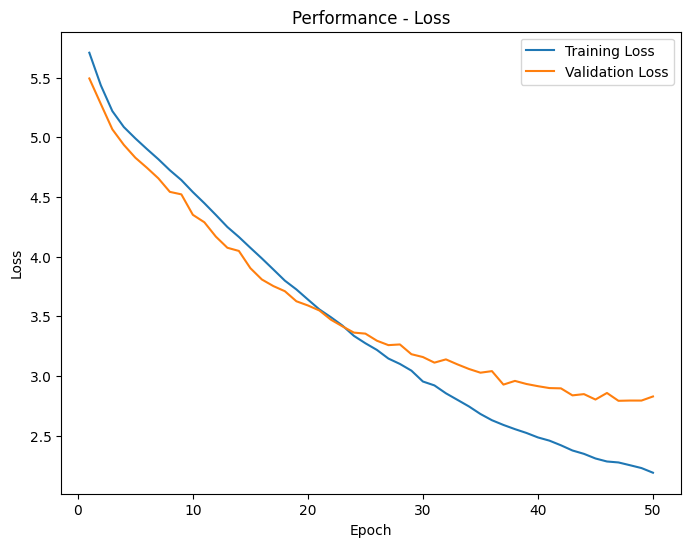

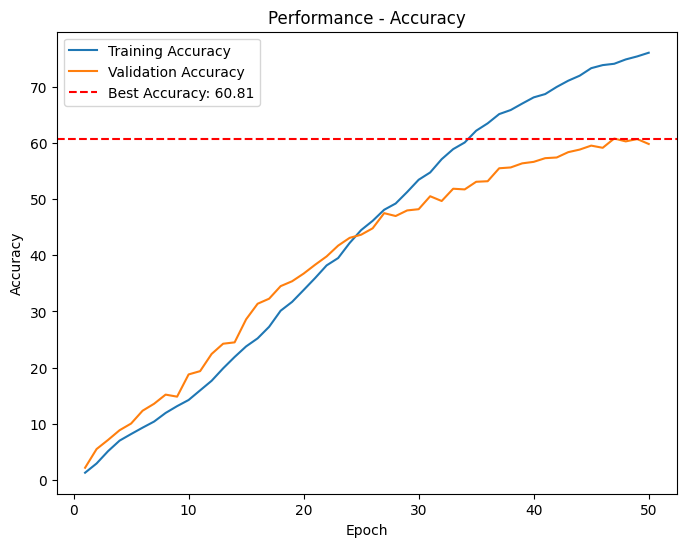

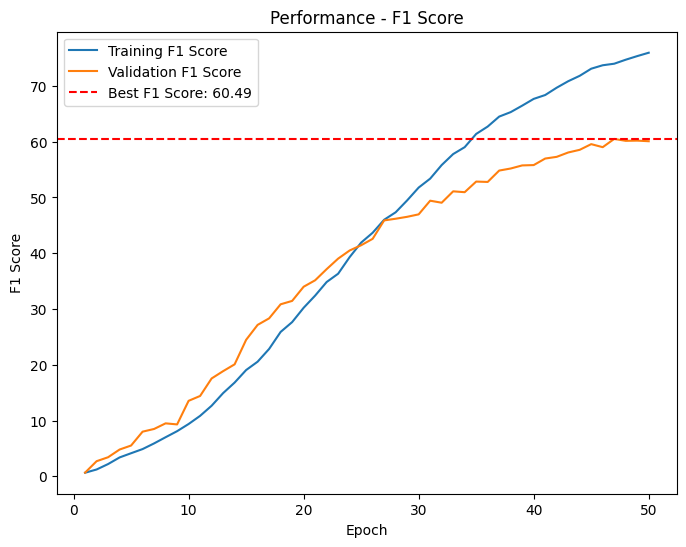

In [242]:
from utilities import visual
history = {
    'train_loss': epoch_train_loss,
    'valid_loss': valid_loss,
    'train_acc': train_accuracy,
    'valid_acc': valid_accuracy,
    'best_accuracy': best_acc, 
    'train_weighted_f1': train_weighted_f1,
     'valid_weighted_f1': valid_weighted_f1,
    'best_f1_score':best_f1_score

}

title = 'Performance'
visual.plot_results(history,target_dir, title)

In [244]:
 # Should print something like (286, 286) if there are 286 classes
print(len(class_names))

287


In [245]:
# valid
valid_loss=[]
valid_accuracy=[]
valid_weighted_f1=[]
y_pred = []
y_true = []
model = Resnet50(num_classes=num_classes, pretrained=True, fine_tune=False)
model.load_state_dict(torch.load(f'{target_dir}/resnet_best.pth'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()
history_val = valid_model(model, valid_dataloader, loss_fn, device)
        # Append result
y_pred.extend(history_val[2])
y_true.extend(history_val[3])

Model: Resnet50
[INFO]: Number of infeatures:2048
[INFO]: Freezing hidden layers...
Validation...


100%|██████████| 172/172 [00:11<00:00, 14.43it/s]


In [246]:
print('Weighted F1: {:.4f}'.format(history_val[4]))

Weighted F1: 60.4868


In [247]:
print("Accuracy on Validation set: ", accuracy_score(y_true, y_pred))
classificationReport = classification_report(y_true, y_pred)
with open(f'{target_dir}/classificationReport.txt', 'w') as file:
    file.write(f'Classification report:\n {classificationReport}')
    file.close()
    
print('Classification report: \n', classificationReport)

Accuracy on Validation set:  0.6080719669341114
Classification report: 
               precision    recall  f1-score   support

           0       0.57      0.31      0.40        13
           1       0.69      0.60      0.64        15
           2       0.38      0.67      0.49        15
           3       0.27      0.43      0.33        14
           4       0.67      1.00      0.80        16
           5       0.78      0.88      0.82         8
           6       0.89      0.94      0.92        18
           7       0.43      0.91      0.59        11
           8       0.92      0.80      0.86        15
           9       0.93      0.93      0.93        15
          10       0.67      0.57      0.62        14
          11       0.60      0.63      0.62        19
          12       0.83      0.29      0.43        17
          13       0.27      0.29      0.28        14
          14       0.88      1.00      0.94        15
          15       0.38      0.27      0.32        11
        

In [248]:
class_names[203]

'Nomi'

Confusion matrix: 
 [[ 4  1  1 ...  0  0  0]
 [ 0  9  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ...  8  0  0]
 [ 0  0  0 ...  0 11  0]
 [ 0  0  0 ...  0  0 10]]


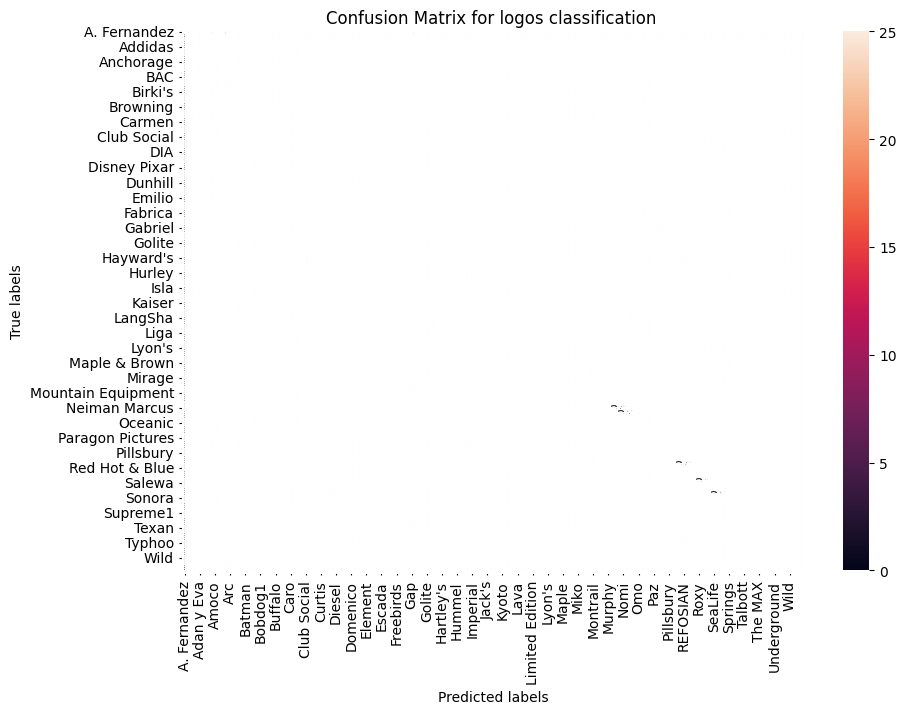

In [249]:
# Build confusion matrix
print('Confusion matrix: \n', confusion_matrix(y_true, y_pred))
# Plot
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in class_names], columns = [i for i in class_names])
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.title("Confusion Matrix for logos classification ")
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.savefig(f'{target_dir}/Confusion_Matrix.png')
plt.show()

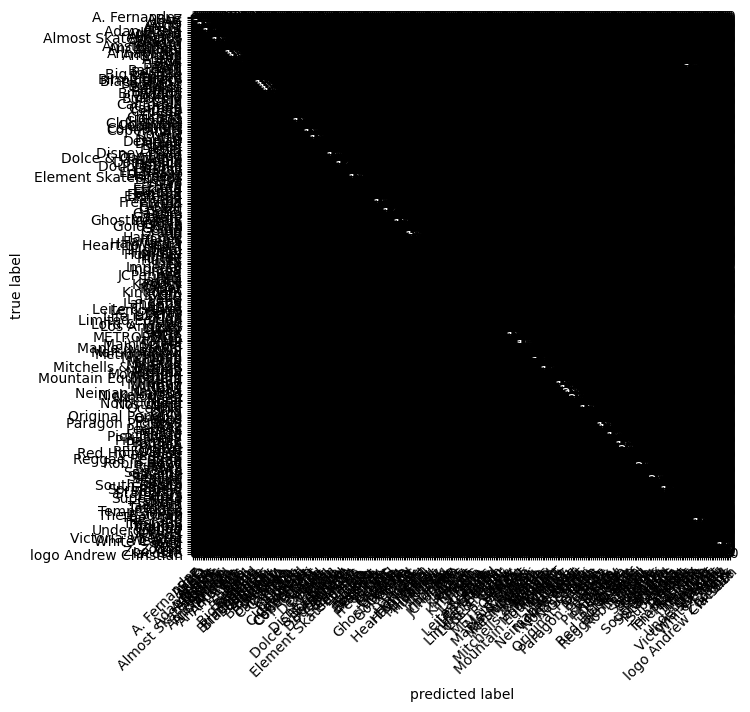

In [250]:
y_true = torch.tensor(y_true)
y_pred = torch.tensor(y_pred)

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred, target=y_true)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib works with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [251]:
y_pred.size()

torch.Size([4113])

In [252]:
y_true

tensor([208, 154, 119,  ..., 179,   9,  11])

In [43]:
cf_matrix

array([[ 4,  0,  0, ...,  0,  0,  0],
       [ 0, 11,  0, ...,  0,  0,  0],
       [ 0,  0, 12, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  9,  0,  0],
       [ 0,  0,  0, ...,  0, 12,  0],
       [ 0,  0,  0, ...,  0,  0, 10]])

# Load Saved Model

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image

#current_exp_dir = 'models/2024-04-24_8:59'
# Load the saved model with custom class number
#model = Resnet18(num_classes=num_classes, pretrained=True, fine_tune=True)
#model.load_state_dict(torch.load(f'{target_dir}/resnet_best.pth'))


### USE MODEL OR NEW_MODEL 
# Create a new model and adjust its final layer
new_model = models.resnet50(pretrained=True)
new_model.fc = nn.Sequential(
    nn.Linear(new_model.fc.in_features, num_classes),
    nn.Sigmoid()
)
# Correctly copy the weights and biases from the loaded model to the new model
#new_model.fc[0].weight.data = model.fc[0].weight.data.clone()
#new_model.fc[0].bias.data = model.fc[0].bias.data.clone()

### Get some images from the Dataset

### Evaluation 

## Clasification on unseen Image

In [ ]:
# Load and preprocess the unseen image
image_path = 'img/boeing_img000019_34_0.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [ ]:
# Perform inference
with torch.no_grad():
    output = model(input_batch.to(device))

# Get the predicted class
_, predicted_class = output.max(1)
# Map the predicted class to the class name
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

In [ ]:
class_names[155]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('off')
plt.text(1 , 1 ,f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='green')
plt.show()

In [ ]:
with open("Datasets/brands.txt", "r") as file:
    lines = file.readlines()

lines_upper = [line.upper() for line in lines]

unique_lines = set()
duplicate_lines = []

for line in lines_upper:
    if line in unique_lines:
        duplicate_lines.append(line)
    else:
        unique_lines.add(line)
print(f'{len(unique_lines)} Brands')